# Welcome to the JupyterLab Version of the NanoObjectDetection Package

## First Load the standard libraries

In [1]:
# Standard Libraries
from __future__ import division, unicode_literals, print_function # For compatibility with Python 2 and 3
from importlib import reload # only used for debugging --> reload(package_name)

# for easy debugging
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import qgrid

import sys
import os
sys.path.insert(0, os.path.abspath(r'C:\Users\foersterronny\Documents\GitHub'))

# Own Library
import NanoObjectDetection as nd

debugger = False
NewEvaluation = False

## Execute this for new data

In [2]:
if NewEvaluation == True: nd.Start.NewEvaluation()

## path of parameter file

In [3]:
#%% 
# this can be replaced by any json file
ParameterJsonFile = \
r'\\mars\usr\FA2_Faseroptik\FAG24_Faseropt_Systeme\Foerster\Data\NanoObjectDetection\5er_revolver_1214b2\TrackingSetupOlympus\Gold\Laser_532nm\Torsten\50nm_9600us_100fps_2000pics\parameter.json'

## read in the raw data into numpy

In [4]:
rawframes_np = nd.handle_data.ReadData2Numpy(ParameterJsonFile)

reload(nd.JupyterLab)
nd.JupyterLab.Show3dImage(rawframes_np)

start reading in raw images. (That may take a while...)
\\mars\usr\FA2_Faseroptik\FAG24_Faseropt_Systeme\Foerster\Data\NanoObjectDetection\5er_revolver_1214b2\TrackingSetupOlympus\Gold\Laser_532nm\Torsten\50nm_9600us_100fps_2000pics\50nm_9600us_100fps_2000pics.tif
finishied reading in raw images =)


interactive(children=(IntSlider(value=1, description='Frame', max=499, min=1), IntRangeSlider(value=(0, 149), …

## ROI - Set Parameters

In [5]:
reload(nd.JupyterLab)
nd.JupyterLab.ChooseROIParameters(rawframes_np, ParameterJsonFile)

interactive(children=(IntSlider(value=0, description='Apply ROI (0 - no, 1 - yes)', max=1), Output()), _dom_cl…

## ROI - Apply

In [6]:
rawframes_super = nd.handle_data.UseROI(rawframes_np, ParameterJsonFile)

#ignore supersamping for the moment since it is not really used, yet

ROI NOT applied


## Standard Image Preprocessing - Set Parameters

In [7]:
reload(nd.PreProcessing)
reload(nd.JupyterLab)
nd.JupyterLab.ChoosePreProcessingParameters(rawframes_super, ParameterJsonFile)

interactive(children=(IntSlider(value=0, description='Correct Laser fluctuations (0 - no, 1 - yes)', max=1), O…

interactive(children=(IntSlider(value=1, description='Correct camera offset (0 - no, 1 - yes)', max=1), Output…

interactive(children=(IntSlider(value=1, description='Correct static background (0 - no, 1 - yes)', max=1), Ou…

RollingPercentilFilter not inserted yet
Clipping negative values not inserted yet. Clipping is bad


interactive(children=(IntSlider(value=1, description='Enhance SNR by convolving with the PSF (0 - no, 1 - yes)…

Rotating the image is not inserted yet. Rotate your camera if that is a problem.


## Standard Image Preprocessing - Apply

In [ ]:
reload(nd.PreProcessing)
reload(nd.JupyterLab)
rawframes_pre, static_background = nd.PreProcessing.Main(rawframes_super, ParameterJsonFile)
nd.JupyterLab.Show3dImage(rawframes_pre)

Laser fluctuations: not removed
Constant camera background: start removing
Camera offset is:  0.0
Constant camera background: removed
Static background: start removing
Static background: removed
Rolling percentil filter: not applied
Negative values: kept
Convolve rawframe by PSF to enhance SNR: start removing
Gauss Kernel in px: 1.3337057150202183
Do it parallel


## help with the parameters for finding objects 

In [ ]:
settings = nd.handle_data.ReadJson(ParameterJsonFile)

reload(nd.ParameterEstimation)
reload(nd.JupyterLab)
reload(nd.get_trajectorie)
reload(nd.AdjustSettings)
nd.JupyterLab.ChooseFindObjParameters(rawframes_super, ParameterJsonFile)

#nd.AdjustSettings.AdjustSettings_Main(rawframes_pre, ParameterJsonFile)

## find the objects

In [11]:
reload(nd.get_trajectorie)
obj_all = nd.get_trajectorie.FindSpots(rawframes_pre, ParameterJsonFile)

qgrid.show_grid(obj_all, show_toolbar=True)

Frame 499: 28 features
Set all NaN in estimation precision to 0


QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

## identify static objects - find trajectories of very slow diffusing (maybe stationary) objects

In [12]:
reload(nd.get_trajectorie)

t1_orig_slow_diff = nd.get_trajectorie.link_df(obj_all, ParameterJsonFile, SearchFixedParticles = True)
# qgrid.show_grid(t1_orig_slow_diff, show_toolbar=True)

# delete trajectories which are not long enough. stationary objects have long trajcetories and survive the test   
t2_stationary = nd.get_trajectorie.filter_stubs(t1_orig_slow_diff, ParameterJsonFile, FixedParticles = True, BeforeDriftCorrection = True)

qgrid.show_grid(t2_stationary, show_toolbar=True)

Frame 499: 32 trajectories present.
New method here.
Minimum trajectorie length:  30.0
Number of stationary objects (might be detected multiple times after being dark): 0


QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

## cut trajectories when a moving particles comes to close to a stationary object

In [13]:
obj_moving = nd.get_trajectorie.RemoveSpotsInNoGoAreas(obj_all, t2_stationary, ParameterJsonFile)

#qgrid.show_grid(obj_moving, show_toolbar=True)

min_distance to stationary object:  20


## remove overexposed objects

In [14]:
obj_moving = nd.get_trajectorie.RemoveOverexposedObjects(ParameterJsonFile, obj_moving, rawframes_pre)
# qgrid.show_grid(obj_moving, show_toolbar=True)

Deleted overexposed particles!


## form trajectories of valid particle positions

In [13]:
t1_orig = nd.get_trajectorie.link_df(obj_moving, ParameterJsonFile, SearchFixedParticles = False) 
qgrid.show_grid(t1_orig, show_toolbar=True)

Frame 499: 30 trajectories present.


QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

## remove to short trajectories

In [14]:
t2_long = nd.get_trajectorie.filter_stubs(t1_orig, ParameterJsonFile, FixedParticles = False, BeforeDriftCorrection = True)
qgrid.show_grid(t2_long, show_toolbar=True)

Minimum trajectorie length:  30.0
Too short trajectories removed!
Before: 1199, After: 88, Removed: 1111 (92%)


QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

## identify and close gaps in the trajectory & calculate intensity fluctuations as a sign of wrong assignment

In [15]:
t3_gapless = nd.get_trajectorie.close_gaps(t2_long)
t3_gapless = nd.get_trajectorie.calc_intensity_fluctuations(t3_gapless, ParameterJsonFile)
# qgrid.show_grid(t3_gapless, show_toolbar=True)

Close gaps in trajectories: [##################################################] 100% DONE


## split trajectories if necessary (e.g. to large intensity jumps)

In [16]:
t4_cutted, t4_cutted_no_gaps = nd.get_trajectorie.split_traj(t2_long, t3_gapless, ParameterJsonFile)
# qgrid.show_grid(t4_cutted, show_toolbar=True)

Split trajectories at high intensity jumps: [##################################################] 100% DONE
Trajectories with risk of wrong assignments (i.e. before splitting): 88
Trajectories with reduced risk of wrong assignments (i.e. after splitting): 89
Number of performed trajectory splits: 396
Number of concerned trajectories: 51 (57%)
Number of trajectories that became too short and were filtered out: 127
Close gaps in trajectories: [##################################################] 100% DONE


## drift correction

In [22]:
reload(nd.Drift)

t5_no_drift = nd.Drift.DriftCorrection(t4_cutted, ParameterJsonFile, PlotGlobalDrift = False)
qgrid.show_grid(t5_no_drift, show_toolbar=True)

The drift correction is done by averaging over:  4  frames
Mode: global drift correction
drift correction --> finished


QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

## only long trajectories are used in the msd plort in order to get a good fit

In [38]:
reload(nd.get_trajectorie)
reload(nd.CalcDiameter)
t6_final = nd.get_trajectorie.filter_stubs(t5_no_drift, ParameterJsonFile, FixedParticles = False, BeforeDriftCorrection = False)
# qgrid.show_grid(t6_final, show_toolbar=True)

# t5_no_drift[t5_no_drift == 4]

Minimum trajectorie length:  150.0
Too short trajectories removed!
Before: 89, After: 18, Removed: 71 (79%)
particleid:  4.0


AttributeError: 'DataFrame' object has no attribute 'frame'

## calculate the msd and process to diffusion and diameter


 Particle number:  30
Starting Diameter: 101.1nm; hindrance factor: 1.036; Corrected Diameter: 97.74nm

 Particle number:  32
To many holes in trajectory to have enough data points. 
 Number of data points must be larger than (amount_summands * lagtimes_max). 
 Consider optimizing parameters Dark tim, Min_tracking_frames, amount_summands, lagtimes_max

 Particle number:  41
Starting Diameter: 94.8nm; hindrance factor: 1.034; Corrected Diameter: 91.75nm

 Particle number:  53
Starting Diameter: 110.4nm; hindrance factor: 1.038; Corrected Diameter: 106.36nm

 Particle number:  58
Trajectory is to short to have enough data points. 
 Trajectorie length must be larger than (amount_summands * lagtimes_max). 
 Consider optimizing parameters Min_tracking_frames, amount_summands, lagtimes_max.

 Particle number:  63
Starting Diameter: 116.0nm; hindrance factor: 1.040; Corrected Diameter: 111.57nm

 Particle number:  74
Starting Diameter: 203.6nm; hindrance factor: 1.062; Corrected Diameter: 19

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

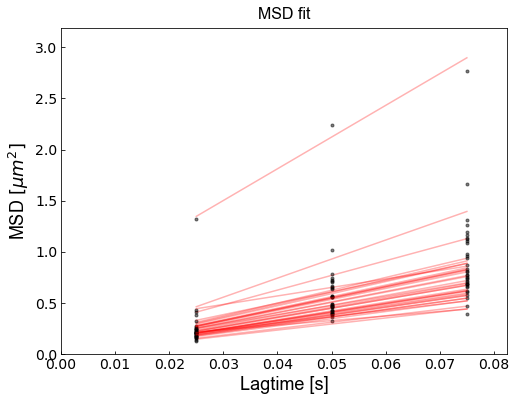

In [78]:
reload(nd.CalcDiameter)
sizes_df_lin, sizes_df_lin_rolling , any_successful_check = nd.CalcDiameter.Main(t6_final, ParameterJsonFile, obj_all, MSD_fit_Show = True)
qgrid.show_grid(sizes_df_lin, show_toolbar=True)

## visualiz results

ValueError: `bins` must be positive, when an integer

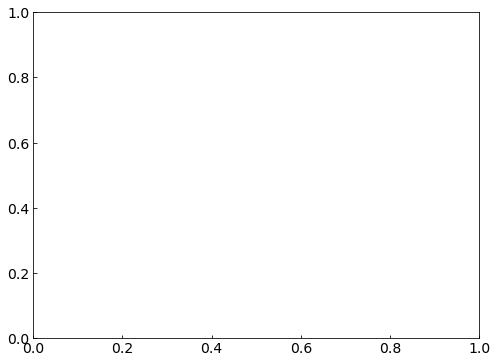

In [48]:
nd.visualize.PlotDiameters(ParameterJsonFile, sizes_df_lin, any_successful_check)

In [ ]:
fig = plt.figure()
import matplotlib.colors as colors


In [ ]:
from ipywidgets import IntSlider, IntRangeSlider, FloatLogSlider
import matplotlib.colors as colors

[max_f, max_y, max_x] = np.asarray(rawframes_ROI.shape) - 1

def ShowRawImage(frame, y_range, x_range, my_gamma):  
    
    fig, axes = plt.subplots(3,1, sharex = True,figsize=(15,10))
    
    y_min = y_range[0]
    y_max = y_range[1]+1
    x_min = x_range[0]
    x_max = x_range[1]+1
     
    axes[0].imshow(rawframes_ROI[frame,y_min:y_max, x_min:x_max], cmap = 'gray', norm=colors.PowerNorm(gamma=my_gamma))
    axes[0].set_title("Raw Image")
    axes[0].set_ylabel("y [Px]")
    
    axes[1].imshow(static_background[y_min:y_max, x_min:x_max], cmap = 'gray', norm=colors.PowerNorm(gamma=my_gamma))
    axes[1].set_title("Background")
    axes[1].set_ylabel("y [Px]")
    
    axes[2].imshow(rawframes_pre[frame, y_min:y_max, x_min:x_max], cmap = 'gray', norm=colors.PowerNorm(gamma=my_gamma))
    axes[2].set_title("Corrected Background")
    axes[2].set_xlabel("x [Px]")
    axes[2].set_ylabel("y [Px]")    
    
    fig.tight_layout()
    
    
frame_slider = IntSlider(min = 1, max = max_f, description = "Frame")    
y_range_slider = IntRangeSlider(value=[0, max_y], min=0, max=max_y, description = "ROI - y")
x_range_slider = IntRangeSlider(value=[0, max_x], min=0, max=max_x, description = "ROI - x")
gamma_slider = FloatSlider(min = 0.1, max = 2, step = 0.05, value = 1)  
    
interact(ShowRawImage, frame = frame_slider, y_range = y_range_slider, x_range = x_range_slider, my_gamma = gamma_slider)

In [ ]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
# run "jupyter nbextension enable --py widgetsnbextension" in anaconda prompt
# conda install -n base -c conda-forge widgetsnbextension
# conda install -c conda-forge nodejs
# jupyter labextension install @jupyter-widgets/jupyterlab-manager

import numpy as np
import matplotlib.pyplot as plt
def f(x):
    plt.plot(np.arange(0,10), x*np.arange(0,10))
    plt.ylim(-30,30)
    
interact(f, x=1)

NameError: name 'sizes_df_lin' is not defined